#### Project Summary

- Use computer vision and AI to scan an image detecting page flips
- recognizes corners and crops pages
- keeps text formatting using contrast between page background
- videos are clipped and labelled to show flip and not flipped
- predict if a page is being flipped using the images

#### Initial Thoughts

- use deep learning environment for computer vision (keras/pytorch/tensorflow) CNN
- set up docker/aws
- preprocess data
- build model
- fit model
- evaluate
- improve model
- save the trained model

docker commands:

docker image ls

docker run  --rm  -p 8888:8888 --gpus all -it -v "H:\Lighthouse Labs\deep_learning":/home/jovyan/work/     jupyter/tensorflow-notebook

####
https://medium.com/nybles/create-your-first-image-recognition-classifier-using-cnn-keras-and-tensorflow-backend-6eaab98d14dd

#### Code

In [3]:
!pip install opencv-python

In [4]:
import tensorflow as tf
import cv2
import os
from matplotlib import pyplot as plt
import pandas as pd
from collections import deque 
import copy
import numpy as np

2023-10-18 10:46:37.813422: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-18 10:46:38.043809: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-18 10:46:38.045403: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 10:46:39.280317: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


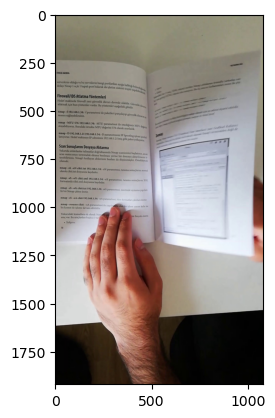

In [5]:
img = cv2.imread(os.path.join("../data/training", 'flip', '0001_000000010.jpg'))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
training = tf.keras.utils.image_dataset_from_directory('../data/training')

Found 2392 files belonging to 2 classes.


In [7]:
testing = tf.keras.utils.image_dataset_from_directory('../data/testing')

Found 597 files belonging to 2 classes.


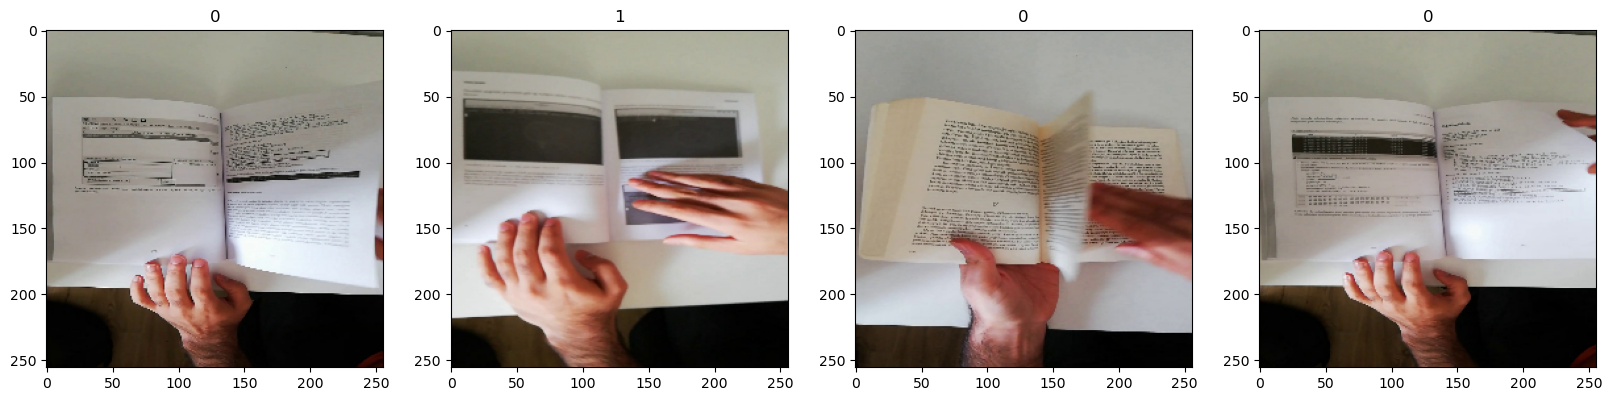

In [8]:
training_iterator = training.as_numpy_iterator()
batch = training_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [9]:
training = training.map(lambda x,y: (x/255, y))

In [10]:
testing = testing.map(lambda x,y: (x/255, y))

##### Model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import TimeDistributed, LSTM, BatchNormalization

In [10]:
# model that only reads one image at a time - Image Classification
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [11]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [13]:
logdir='logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(training, epochs=10, validation_data=testing, callbacks=[tensorboard_callback])

Epoch 1/10
75/75 [==============================] - 42s 550ms/step - loss: 0.6851 - accuracy: 0.5857 - val_loss: 0.5305 - val_accuracy: 0.7621
Epoch 2/10
75/75 [==============================] - 31s 400ms/step - loss: 0.3073 - accuracy: 0.8671 - val_loss: 0.1785 - val_accuracy: 0.9213
Epoch 3/10
75/75 [==============================] - 31s 408ms/step - loss: 0.1042 - accuracy: 0.9615 - val_loss: 0.0800 - val_accuracy: 0.9749
Epoch 4/10
75/75 [==============================] - 31s 406ms/step - loss: 0.0564 - accuracy: 0.9820 - val_loss: 0.0462 - val_accuracy: 0.9899
Epoch 5/10
75/75 [==============================] - 31s 409ms/step - loss: 0.0305 - accuracy: 0.9904 - val_loss: 0.0478 - val_accuracy: 0.9849
Epoch 6/10
75/75 [==============================] - 32s 413ms/step - loss: 0.0371 - accuracy: 0.9862 - val_loss: 0.1414 - val_accuracy: 0.9531
Epoch 7/10
75/75 [==============================] - 31s 407ms/step - loss: 0.0243 - accuracy: 0.9921 - val_loss: 0.0271 - val_accuracy: 0.9933

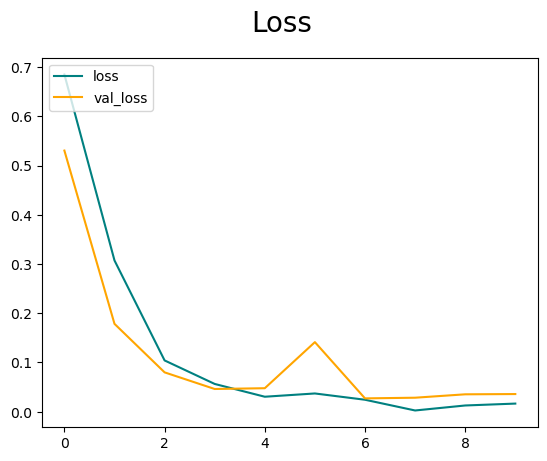

In [14]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

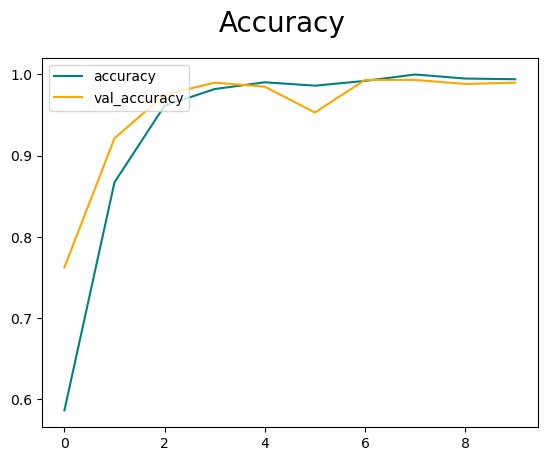

In [15]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [12]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, F1Score

In [17]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
f1 = F1Score(threshold = 0.5)

In [31]:
# from tensorflow.keras.models import load_model
# new_model = load_model('../models/flipclassifier.keras')

In [18]:
for batch in testing.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 103ms/step


In [19]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.987055, shape=(), dtype=float32) tf.Tensor(0.99348533, shape=(), dtype=float32) tf.Tensor(0.98994976, shape=(), dtype=float32)


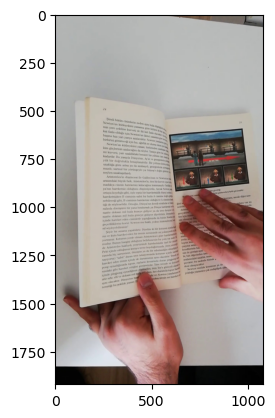

In [40]:
img = cv2.imread('../data/testing/notflip/0031_000000016.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

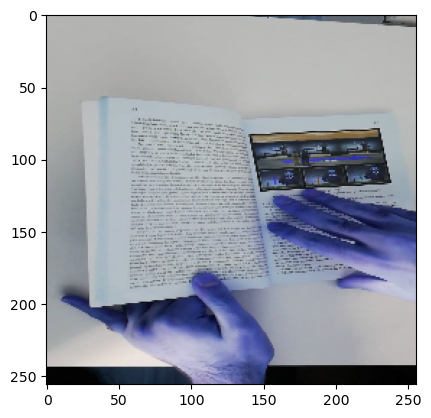

In [41]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [42]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 21ms/step


In [43]:
if yhat > 0.5: 
    print(f'Predicted class is notflip')
else:
    print(f'Predicted class is flip')

Predicted class is notflip


In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('../models','flipclassifier.keras'))

In [46]:
new_model = load_model('../models/flipclassifier.keras')

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 56ms/step


array([[0.97548324]], dtype=float32)

In [ ]:
####

#### Video Classification

In [13]:
print(os.getcwd())

/home/jovyan/work/Apziva_P4/src


In [14]:
data_path = "/home/jovyan/work/Apziva_P4/data"

In [15]:
# write function to different folders function

def write_images(type):
    for folder in os.listdir(os.path.join(data_path, type)):
        video_path = os.path.join(data_path, "videos")
        image_path = os.path.join(os.path.join(data_path, type), folder)
        video_path = os.path.join(os.path.join(video_path, type), folder)
        try:
            os.makedirs(video_path)
        except:
            print('File already created')
    
        for image in os.listdir(image_path):
            try:
                os.makedirs(os.path.join(video_path, image.split("_")[0]))
            except:
                print('File already created')
            img = cv2.imread(os.path.join(image_path, image))
            cv2.imwrite(os.path.join(os.path.join(video_path, image.split("_")[0]), image.split("_")[-1]), img)

In [7]:
# write_images('testing')

File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already created
File already 

KeyboardInterrupt: 

In [16]:
# wrjiting csv folders
def write_csv(type):
    video_path = os.path.join(data_path, 'videos')
    type_video_path = os.path.join(video_path, type)
    
    for folder in os.listdir(type_video_path):
        path_to_video = os.path.join(type_video_path, folder)
        for video in os.listdir(path_to_video):
            data = {'FileName':[], 'Label':[]}
            if video != ".ipynb_checkpoints":
                image_path = os.path.join(path_to_video, video)
                for frame in os.listdir(image_path):
                    data['FileName'].append(os.path.join(image_path, frame))
                    data['Label'].append(folder)
                    # repeat the last image 
                file_name = '{}.csv'.format(video)
                data_df = pd.DataFrame(data, index = None, columns = data.keys())
                data_df.to_csv(data_path+'/csv/{}/{}/{}'.format(type, folder, file_name))

In [17]:
# write_csv('training')

In [18]:
# write_csv('testing')

In [19]:
def file_generator(csv_folder, temporal_stride, temporal_length):
    '''
    Creates a python generator that 'yields' a sequence of frames every time
    based on the temporal length and stride.
    '''
    for file in [f for f in os.listdir(csv_folder) if not f.startswith('.')]:
        data = pd.read_csv(os.path.join(csv_folder, file))
        labels = list(data.Label)
        total_images = len(labels)
        num_samples = int((total_images - temporal_length)/temporal_stride) +1
        if total_images >= temporal_length:
            print('Number of samples from sequence-{}: {}'.format(file, num_samples))
        else:
            print('Padding {} frames, 1 sample from sequence-{}'.format(temporal_length-total_images, file))

        img_list = list(data.FileName)
        samples = deque()
        sample_count = 0

        while len(img_list) < 8:
            img_list.append(img_list[-1])
            labels.append(labels[-1])
            
        for img in img_list:
            samples.append(img)
            if len(samples) == temporal_length:
                samples_c = copy.deepcopy(samples)
                sample_count += 1
                for i in range(temporal_stride):
                    samples.popleft()
                yield samples_c, labels[0]
        
                

In [20]:
def load_samples(data, temporal_stride = 1, temporal_length = 16):
    data_path = os.path.join("/home/jovyan/work/Apziva_P4/data/csv", data)
    data_list = []
    
    for folder in [f for f in os.listdir(data_path) if not f.startswith('.')]:
        # run the file gen on each folder flip/notflip
        file_gen = file_generator(os.path.join(data_path, folder), temporal_stride, temporal_length)
        iterator = True
        while iterator:
            try:
                x, y = next(file_gen)
                x = list(x)
                data_list.append([x,y])
            except:
                iterator = False
    return data_list

In [22]:
train_data = load_samples('training', 1, 8)

Number of samples from sequence-0001.csv: 8
Number of samples from sequence-0002.csv: 2
Number of samples from sequence-0003.csv: 15
Number of samples from sequence-0004.csv: 13
Number of samples from sequence-0005.csv: 18
Number of samples from sequence-0006.csv: 14
Number of samples from sequence-0007.csv: 16
Number of samples from sequence-0008.csv: 17
Number of samples from sequence-0009.csv: 14
Number of samples from sequence-0010.csv: 14
Number of samples from sequence-0011.csv: 14
Number of samples from sequence-0012.csv: 10
Number of samples from sequence-0013.csv: 15
Number of samples from sequence-0014.csv: 5
Number of samples from sequence-0015.csv: 18
Number of samples from sequence-0016.csv: 17
Number of samples from sequence-0017.csv: 10
Number of samples from sequence-0018.csv: 14
Number of samples from sequence-0019.csv: 10
Number of samples from sequence-0020.csv: 7
Number of samples from sequence-0021.csv: 10
Number of samples from sequence-0022.csv: 9
Number of sampl

In [23]:
test_data = load_samples('testing', 1, 8)

Padding 7 frames, 1 sample from sequence-0001.csv
Padding 4 frames, 1 sample from sequence-0002.csv
Padding 4 frames, 1 sample from sequence-0003.csv
Padding 4 frames, 1 sample from sequence-0004.csv
Padding 3 frames, 1 sample from sequence-0005.csv
Number of samples from sequence-0006.csv: 2
Padding 5 frames, 1 sample from sequence-0007.csv
Padding 3 frames, 1 sample from sequence-0008.csv
Padding 1 frames, 1 sample from sequence-0009.csv
Padding 2 frames, 1 sample from sequence-0010.csv
Padding 3 frames, 1 sample from sequence-0011.csv
Padding 1 frames, 1 sample from sequence-0012.csv
Padding 3 frames, 1 sample from sequence-0013.csv
Number of samples from sequence-0014.csv: 4
Padding 3 frames, 1 sample from sequence-0015.csv
Padding 3 frames, 1 sample from sequence-0016.csv
Padding 6 frames, 1 sample from sequence-0017.csv
Padding 3 frames, 1 sample from sequence-0018.csv
Padding 6 frames, 1 sample from sequence-0019.csv
Padding 2 frames, 1 sample from sequence-0020.csv
Padding 4 fr

In [24]:
print(len(train_data))
print(len(test_data))

1576
142


In [25]:
train_data[1337]

[['/home/jovyan/work/Apziva_P4/data/videos/training/notflip/0045/000000015.jpg',
  '/home/jovyan/work/Apziva_P4/data/videos/training/notflip/0045/000000017.jpg',
  '/home/jovyan/work/Apziva_P4/data/videos/training/notflip/0045/000000019.jpg',
  '/home/jovyan/work/Apziva_P4/data/videos/training/notflip/0045/000000020.jpg',
  '/home/jovyan/work/Apziva_P4/data/videos/training/notflip/0045/000000021.jpg',
  '/home/jovyan/work/Apziva_P4/data/videos/training/notflip/0045/000000023.jpg',
  '/home/jovyan/work/Apziva_P4/data/videos/training/notflip/0045/000000024.jpg',
  '/home/jovyan/work/Apziva_P4/data/videos/training/notflip/0045/000000025.jpg'],
 'notflip']

In [26]:
test_data[37]

[['/home/jovyan/work/Apziva_P4/data/videos/testing/flip/0036/000000007.jpg',
  '/home/jovyan/work/Apziva_P4/data/videos/testing/flip/0036/000000008.jpg',
  '/home/jovyan/work/Apziva_P4/data/videos/testing/flip/0036/000000009.jpg',
  '/home/jovyan/work/Apziva_P4/data/videos/testing/flip/0036/000000011.jpg',
  '/home/jovyan/work/Apziva_P4/data/videos/testing/flip/0036/000000014.jpg',
  '/home/jovyan/work/Apziva_P4/data/videos/testing/flip/0036/000000015.jpg',
  '/home/jovyan/work/Apziva_P4/data/videos/testing/flip/0036/000000024.jpg',
  '/home/jovyan/work/Apziva_P4/data/videos/testing/flip/0036/000000024.jpg'],
 'flip']

In [27]:
from sklearn.preprocessing import LabelEncoder
### data generator
le = LabelEncoder()
def data_generator(data, batch_size = 10):
    '''
    Yield the next training batch.
    data is an array containing [[[frame1, ..., frameN], label], [[frame1, ..., frameN], label], ...]
    '''
    num_samples = len(data)
    while True:
        for offset in range(0, num_samples, batch_size):

            batch_samples = data[offset:offset+batch_size]
            
            X_set = []
            y_set = []

            for batch_sample in batch_samples:
                x = batch_sample[0]
                y = batch_sample[1]
                temp_data_list = []
                for img in x:
                    try:
                        img = cv2.imread(img)
                        # preprocess
                        img = cv2.resize(img, (256,256))
                        img = img/255
                        temp_data_list.append(img)
                    except Exception as e:
                        print(e)
                        print('Error reading file: ', img)
                X_set.append(temp_data_list)
                y_set.append(y)
                

            X_set = np.array(X_set)
            y_set = le.fit_transform(y_set)
            y_set = np.array(y_set)

            yield X_set, y_set
                        
              

In [28]:
train_gen = data_generator(train_data, batch_size = 32)

In [29]:
test_gen = data_generator(test_data, batch_size = 32)

In [30]:
### cnn - LSTM video classification

# new model with CNN - LSTM - Video Classification
cnn_lstm = Sequential()
cnn_lstm.add(TimeDistributed(Conv2D(16, (3,3), 1, activation='relu'), input_shape=(8,256,256,3)))
cnn_lstm.add(TimeDistributed(MaxPooling2D()))
cnn_lstm.add(TimeDistributed(Conv2D(32, (3,3), 1, activation='relu')))
cnn_lstm.add(TimeDistributed(MaxPooling2D()))
cnn_lstm.add(TimeDistributed(Conv2D(16, (3,3), 1, activation='relu')))
cnn_lstm.add(TimeDistributed(MaxPooling2D()))
cnn_lstm.add(TimeDistributed(BatchNormalization()))

cnn_lstm.add(TimeDistributed(Flatten()))

cnn_lstm.add(LSTM(30))
cnn_lstm.add(Dense(256, activation='relu'))
cnn_lstm.add(Dense(1, activation='sigmoid'))

# cnn first then lstm

In [31]:
cnn_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 8, 254, 254, 16)   448       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 8, 127, 127, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 8, 125, 125, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 8, 62, 62, 32)     0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 8, 60, 60, 16)     4

In [32]:
cnn_lstm.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy', Precision(), Recall()])

In [78]:
logdir='cnn_logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = cnn_lstm.fit(train_gen, validation_data=test_gen, validation_steps = len(test_data)//32, 
                    steps_per_epoch = len(train_data)//32, epochs = 3, callbacks=[tensorboard_callback])

Epoch 1/3
49/49 [==============================] - 624s 13s/step - loss: 0.1276 - accuracy: 0.9819 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 0.6741 - val_accuracy: 0.5312 - val_precision_5: 0.0238 - val_recall_5: 0.0500
Epoch 2/3
49/49 [==============================] - 668s 14s/step - loss: 0.1056 - accuracy: 0.9819 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 0.4409 - val_accuracy: 0.8438 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 3/3
49/49 [==============================] - 652s 14s/step - loss: 0.0930 - accuracy: 0.9819 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 0.4615 - val_accuracy: 0.8438 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00


In [79]:
cnn_lstm.save(os.path.join('../models','videoclassifier.keras'))

In [33]:
from tensorflow.keras.models import load_model
loaded_video_model = load_model('../models/videoclassifier.keras')

In [34]:
pred = loaded_video_model.predict(test_gen, steps = len(test_data), verbose =1)

142/142 [==============================] - 1135s 8s/step


In [38]:
loaded_video_model.evaluate(test_gen, steps = len(test_data)/32, use_multiprocessing=True)

4/4 [==============================] - 52s 13s/step - loss: 0.4263 - accuracy: 0.8592 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00


[0.42627495527267456, 0.8591549396514893, 0.0, 0.0]